# Title

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1g9r82f/q_required_sample_size_to_infer_which_of_two/).

> Required sample size to infer which of two possible values of p a Bernoulli process has?

I'm looking at a Bernoulli process which may have either of two possible values of its trial probability parameter, let's call them q1 and q2. I know these values beforehand, but not which of them is the right one.

I'm interested in finding out which of the two it is, but sampling from the process is quite costly (~10 realtime minutes per sample), so before commiting to this I would like to make a rough estimation for how many samples it will likely take to tell with reasonable confidence (let's say, e.g. 95%) that the one that looks more likely in the running sample is indeed the right one. I'm aware that this required sample size will very sensitively depend on how close to each other q1 and q2 are.

So I suppose I'm looking for an approximation formula that relates sample size n, w.l.o.g. true probability q1, false probability q2, and required confidence level c (and, if that's not too much of a complication, Bayesian prior belief b1 that q1 is indeed true) to each other.

That would give me two estimates which I'm aware cannot really be combined because e.g. sampling q1=0 versus q2=0.1 would let me stop immediately in case q2 is true and the first "1" is observed, for any confidence level, but if q1 is true how many successive "0"s are satisfying to reject q2 does depend on the confidence level.

For actually conducting the experiment, I was just going to apply the law of total probability, using the binomial distribution's probability mass function with observed k and either value of p for the conditional probability update, sampling until either of the two model's posterior probability exceeds the required confidence level c. Is this a valid way to go about it or am I introducing any kind of bias this way?

Intro



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/bernoulli.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

'utils.py'

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Answer

In [4]:
q1 = 0.5
q2 = 0.65

In [5]:
from empiricaldist import Pmf

ps = [0.8, 0.2]
qs = [q1, q2]
prior = Pmf(ps, qs)
prior

,probs
0.50,0.8
0.65,0.2


In [6]:
from scipy.stats import binom

def generate(n, p):
    return n, binom(n, p).rvs()

In [7]:
np.random.seed(1)

In [8]:
n = 10
n, k = generate(n, q1)
k

5

In [9]:
likelihood = binom.pmf(k, n, [q1, q2])
likelihood

array([0.24609375, 0.15357041])

In [10]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
0.50,0.865046
0.65,0.134954


In [11]:
def update(prior, data):
    n, k = data
    likelihood = binom.pmf(k, n, [q1, q2])
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

In [12]:
n = 10
update(prior, generate(n, q1))

,probs
0.50,0.775357
0.65,0.224643


In [13]:
def simulate(n, q, threshold=0.95, iters=3001):
    ns = []
    for i in range(iters):
        ns.append(n)
        posterior = update(prior, generate(n, q))
        if posterior[q] < threshold:
            n += 1
        else:
            n -= 1
    return ns

In [14]:
n0 = 33
ns = simulate(n0, q1)
mean = np.mean(ns)
mean

33.48450516494502

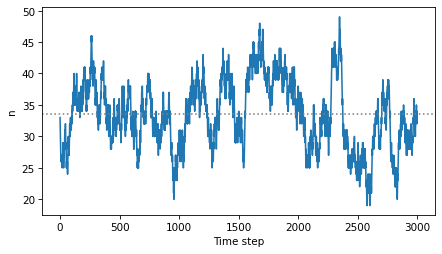

In [15]:
plt.plot(ns)
plt.axhline(mean, ls=':', color='gray')
decorate(xlabel='Time step', ylabel='n')

In [16]:
n0 = 95
ns = simulate(n0, q2)
mean = np.mean(ns)
mean

94.73408863712096

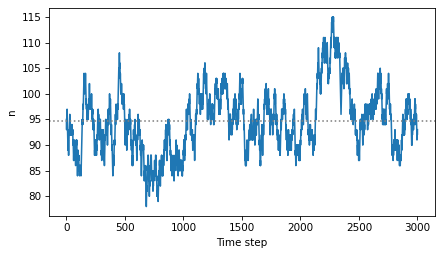

In [17]:
plt.plot(ns)
plt.axhline(mean, ls=':', color='gray')
decorate(xlabel='Time step', ylabel='n')

In [20]:

def run_until_threshold(prior, actual, n=1, threshold=0.95):
    """
    """
    posterior = prior
    for i in range(1, 1001):
        data = generate(n, actual)
        posterior = update(posterior, data)
        for q, p in posterior.items():
            if p >= threshold:
                return i, q

    return -1, np.nan

In [21]:
actual = prior.sample(1)[0]
i, final = run_until_threshold(prior, actual)
actual, i, final

(0.65, 10, 0.5)

In [22]:
res = []
for i in range(1001):
    actual = prior.sample(1)[0]
    i, final = run_until_threshold(prior, actual)
    res.append((actual, i, final))

In [23]:
df = pd.DataFrame(res, columns=['actual', 'steps', 'final'])
df.head()

,actual,steps,final
0,0.5,20,0.5
1,0.5,19,0.5
2,0.5,8,0.5
3,0.5,20,0.5
4,0.5,14,0.5


In [24]:
df['actual'].value_counts(normalize=True)

actual
0.50    0.787213
0.65    0.212787
Name: proportion, dtype: float64

In [25]:
df['steps'].mean()

43.29170829170829

In [26]:
(df['actual'] == df['final']).mean()

0.954045954045954

In [27]:
steps1 = df.loc[df['actual'] == q1, 'steps']
steps1.mean()

35.753807106598984

In [28]:
steps2 = df.loc[df['actual'] == q2, 'steps']
steps2.mean()

71.17840375586854

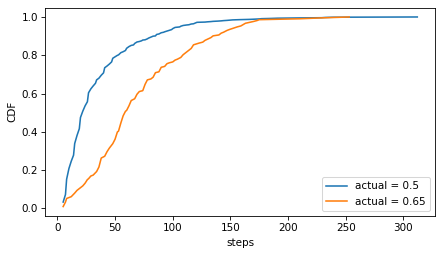

In [29]:
from empiricaldist import Cdf

Cdf.from_seq(steps1).plot(label=f'actual = {q1}')
Cdf.from_seq(steps2).plot(label=f'actual = {q2}')
decorate(ylabel='CDF')

## Discussion

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)